## VMT data for HCD summaries

Notebook for summarizing VMT and related TAZ level data to jurisdiction geographies for the San Francisco Bay Area.

Travel model core summary files described here:
https://github.com/BayAreaMetro/travel-model-one/tree/master/model-files/scripts/core_summaries#vehiclemilestraveled

In [2]:
import glob
import os
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import mapclassify
import matplotlib.pyplot as plt

In [3]:
pct = lambda x: x/x.sum()

In [4]:
countymap_mtc={1:'San Francisco',2:'San Mateo',3:'Santa Clara',4:'Alameda',5:'Contra Costa',6:'Solano',
           7:'Napa',8:'Sonoma',9:'Marin'}

In [12]:
xlwriter = pd.ExcelWriter('/Users/aolsen/Box/RHNA/HCD Review/HCD_VMT_summaries.xlsx',engine='openpyxl')

### Get supporting geography files and population counts

In [13]:
taz = gpd.read_file('https://opendata.arcgis.com/datasets/94e6e7107f0745b5b2aabd651340b739_0.geojson').to_crs('EPSG:26910')

#taz['county']=taz.county_mtc.map(countymap_mtc)
taz=taz[taz.geometry.notnull()]
taz['zone_id']=taz.taz1454
taz.head()

,objectid,taz1454,district,county,gacres,Shape__Area,Shape__Length,geometry,zone_id
0,1,566,11,Santa Clara,"1,708.68",0.00,0.10,"POLYGON ((600337.262 4127333.574, 600264.066 4...",566
1,2,565,11,Santa Clara,486.20,0.00,0.05,"POLYGON ((601170.353 4126571.857, 601276.370 4...",565
2,3,573,11,Santa Clara,538.07,0.00,0.06,"POLYGON ((605271.106 4127581.830, 605217.741 4...",573
3,4,571,11,Santa Clara,450.41,0.00,0.05,"POLYGON ((605855.725 4126303.247, 605633.479 4...",571
4,5,576,11,Santa Clara,423.27,0.00,0.04,"POLYGON ((603870.181 4129745.311, 603817.559 4...",576


In [14]:
## load tpas - this is a multipart blob

tpa = gpd.read_file('https://opendata.arcgis.com/datasets/d97b4f72543a40b2b85d59ac085e01a0_0.geojson').to_crs('EPSG:26910')

In [15]:
jurisdictions = gpd.read_file(
    '/Users/aolsen/Dropbox/Documents/Data/GIS/Census/places_w_remainder_uninc_complete_2019_vintage.shp').to_crs('EPSG:26910')
jurisdictions['juris'] = jurisdictions.jurisdicti

<AxesSubplot:>

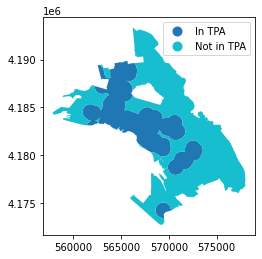

In [16]:
juris_x_tpa = gpd.overlay(jurisdictions,tpa,how='union')
juris_x_tpa['area']=juris_x_tpa.geometry.area
juris_x_tpa=juris_x_tpa[juris_x_tpa.jurisdicti.notna()]
juris_x_tpa['is_tpa'] = juris_x_tpa.objectid.notnull().map({True:'In TPA',False:'Not in TPA'})

juris_x_tpa[juris_x_tpa.jurisdicti=='Oakland'].plot(column='is_tpa',legend=True)

In [17]:
juris_x_tpa.groupby(['jurisdicti','is_tpa']).area.sum().groupby(level='jurisdicti').apply(pct).unstack(1).fillna(0).to_excel(xlwriter,'juris_w_tpa')

In [18]:
jurisdictions2 = gpd.read_file(
    '/Users/aolsen/Dropbox/Documents/Data/GIS/Census/places_w_remainder_uninc_complete_2019_vintage.shp')
jurisdictions2['juris'] = jurisdictions2.jurisdicti

In [19]:
censusblocks_xy = gpd.read_file(
    '/Users/aolsen/Dropbox/Documents/Data/GIS/Census/blocks/tl_2015_06_tabblock10_bayarea_xy.shp').to_crs('EPSG:26910')

In [20]:
jurisdictions = gpd.read_file(
    '/Users/aolsen/Dropbox/Documents/Data/GIS/Census/places_w_remainder_uninc_complete_2019_vintage.shp').to_crs('EPSG:26910')
jurisdictions['juris'] = jurisdictions.jurisdicti

In [21]:
# Load census 2010 block populations - we use these as weights in going from TAZ to jurisdiction

blockpop = pd.read_csv('/Users/aolsen/Dropbox/Data/census2010sf1_blk_age_sex.csv', dtype={
                       'GEOID10_blk': str}).set_index(['GEOID10_blk', 'county', 'juris', 'gender', 'ssa', 'age_grp_5']).value

block_pop_df = blockpop.sum(level=[0]).reset_index(name='value')
block_pop_df['tract'] = block_pop_df.GEOID10_blk.str.slice(0, 11)

block_pop_df.head()

,GEOID10_blk,value,tract
0,060014001001000,0,06001400100
1,060014001001001,0,06001400100
2,060014001001002,0,06001400100
3,060014001001003,0,06001400100
4,060014001001004,0,06001400100


In [22]:
# relate census blocks to tazs

censusblocks_x_taz = gpd.sjoin(
    censusblocks_xy, taz[['geometry', 'zone_id']], how='inner', op='within')


In [23]:
# relate census blocks to jurisdictions

censusblocks_x_juris = gpd.sjoin(censusblocks_xy, jurisdictions[[
                                 'geometry', 'jurisdicti']], how='inner', op='within')

In [24]:
# assign TAZ to block pop df 
# goal is to say for a given TAZ, what is the share of the population in each jurisdiction

block_pop_df['juris'] = block_pop_df.GEOID10_blk.map(
    censusblocks_x_juris.groupby(['GEOID10']).jurisdicti.first())

block_pop_df['taz'] = block_pop_df.GEOID10_blk.map(
    censusblocks_x_taz.groupby(['GEOID10']).zone_id.first())

# variant: using block derived pop weights - many to many
taz_to_juris_share_v2 = block_pop_df.groupby(
    ['taz', 'juris']).value.sum().groupby(level=0, group_keys=False).apply(pct)
taz_to_juris_share_v2.sample(5)

taz       juris     
230.00    Daly City    0.06
596.00    San Jose     1.00
1,244.00  Vallejo      1.00
976.00    Oakland      1.00
1,353.00  Santa Rosa   0.82
Name: value, dtype: float64

In [25]:
#tm_files_2050_path = '/Users/aolsen/Box/RHNA/HCD Review/TM_DATA/2050_TM152_FBP_PlusCrossing_20'
#tm_files_2050 = glob.glob1(tm_files_2050_path, '*')

tm_files_2050_path = '/Users/aolsen/Box/RHNA/HCD Review/TM_DATA/2050_TM152_FBP_PlusCrossing_21'
tm_files_2050 = glob.glob1(tm_files_2050_path, '*')

#tm_files_2020_path = '/Users/aolsen/Box/RHNA/HCD Review/TM_DATA/2020_TM152_FBP_NoProject_16'
#tm_files_2020 = glob.glob1(tm_files_2020_path, '*')

tm_files_2010_path = '/Users/aolsen/Box/RHNA/HCD Review/TM_DATA/RTP2017_2010_05_003'
tm_files_2010 = glob.glob1(tm_files_2010_path, '*')

tm_files_2035_path = '/Users/aolsen/Box/RHNA/HCD Review/TM_DATA/2035_TM152_FBP_Plus_20'
tm_files_2035 = glob.glob1(tm_files_2035_path, '*')



In [26]:
tm_files_2015_path = '/Users/aolsen/Box/RHNA/HCD Review/TM_DATA/2015_TM152_IPA_16'
tm_files_2015 = glob.glob1(tm_files_2015_path, '*')


### Load TM data

In [27]:
which_files = {2010: {'path': tm_files_2010_path, 'file': tm_files_2010},
               2015: {'path': tm_files_2015_path, 'file': tm_files_2015},
               2035: {'path': tm_files_2035_path, 'file': tm_files_2035},
               2050: {'path': tm_files_2050_path, 'file': tm_files_2050}}

In [28]:
# Bulk load TM files into namespace for easy exploration
# read dataframes and assign to global name space
# remove when done and just hand pick the ones we need

YEAR = 2050
for fl in map(lambda x: x.replace('.csv', ''), filter(lambda x: 'csv' in x, which_files[YEAR]['file'])):
    print(fl)
    globals()[fl] = pd.read_csv(os.path.join(
        which_files[YEAR]['path'], '%s.csv' % fl))

AccessibilityMarkets
ActiveTransport
ActivityPattern
AutomobileOwnership
AutoTripsVMT_perOrigDestHomeWork
AutoTripsVMT_personsHomeWork
CommuteByEmploymentLocation
CommuteByIncomeHousehold
CommuteByIncomeJob
JourneyToWork
JourneyToWork_modes
num_ftworkers_with_telecommutable_jobs
PerTripTravelTime
TelecommuteEligibleBySD
TelecommuteEligibleBySDByinc
TimeOfDay
TimeOfDay_personsTouring
TravelCost
TripDistance
VehicleMilesTraveled
VehicleMilesTraveled_households


In [29]:
CommuteByIncomeHousehold = pd.concat(
    [
        pd.read_csv(os.path.join(tm_files_2010_path,
                                 'CommuteByIncomeHousehold.csv')),
        pd.read_csv(os.path.join(tm_files_2015_path,
                                 'CommuteByIncomeHousehold.csv')),
        pd.read_csv(os.path.join(tm_files_2035_path,
                                 'CommuteByIncomeHousehold.csv')),
        pd.read_csv(os.path.join(tm_files_2050_path,
                                 'CommuteByIncomeHousehold.csv')),

    ],
    keys=[('2010_05_003', '2010'),
          ('2015_TM152_IPA_16', '2015'),
          ('2035_TM152_FBP_Plus_20', '2035'),
          ('2050_TM152_FBP_PlusCrossing_21', '2050')],
    names=['scenario', 'year']).reset_index()
CommuteByIncomeHousehold.head()

,scenario,year,level_2,res_COUNTY,res_county_name,res_SD,orig_taz,tour_mode,incQ,incQ_label,freq,totCost,cost,parking_cost,distance,duration,cost_fail,time_fail
0,2010_05_003,2010,0,1,San Francisco,1,1,1,1,Less than $30k,3,573.77,28.77,545.00,1.64,8.01,0,0
1,2010_05_003,2010,1,1,San Francisco,1,1,1,2,$30k to $60k,1,5.40,5.40,0.00,0.24,6.33,0,0
2,2010_05_003,2010,2,1,San Francisco,1,1,1,3,$60k to $100k,2,"1,296.67",43.17,"1,253.50",2.38,8.73,0,0
3,2010_05_003,2010,3,1,San Francisco,1,1,1,4,More than $100k,2,350.33,186.83,163.50,6.04,13.38,0,0
4,2010_05_003,2010,4,1,San Francisco,1,1,3,3,$60k to $100k,1,33.72,33.72,0.00,3.32,10.64,0,0


In [30]:
VehicleMilesTraveled = pd.concat(
    [
        pd.read_csv(os.path.join(tm_files_2010_path,
                                 'VehicleMilesTraveled.csv')),
        pd.read_csv(os.path.join(tm_files_2015_path,
                                 'VehicleMilesTraveled.csv')),
        pd.read_csv(os.path.join(tm_files_2035_path,
                                 'VehicleMilesTraveled.csv')),
        pd.read_csv(os.path.join(tm_files_2050_path,
                                 'VehicleMilesTraveled.csv')),
        
    ],
    keys=[('2010_05_003', '2010'),
          ('2015_TM152_IPA_16', '2015'),
          ('2035_TM152_FBP_Plus_20', '2035'),
          ('2050_TM152_FBP_PlusCrossing_21', '2050')], 
    names=['scenario', 'year']).reset_index()
VehicleMilesTraveled.head()

,scenario,year,level_2,COUNTY,county_name,taz,walk_subzone,walk_subzone_label,ptype,ptype_label,autoSuff,autoSuff_label,freq,vmt_indiv,vmt_joint,vmt,SD,person_trips,vehicle_trips
0,2010_05_003,2010,0,1,San Francisco,1,1,Short-walk to transit (less than one-third of ...,1,Full-time worker,0,Zero automobiles,8,0.00,0.01,0.01,nan,nan,nan
1,2010_05_003,2010,1,1,San Francisco,1,1,Short-walk to transit (less than one-third of ...,1,Full-time worker,2,Automobiles >= workers,21,3.89,0.00,3.89,nan,nan,nan
2,2010_05_003,2010,2,1,San Francisco,1,1,Short-walk to transit (less than one-third of ...,2,Part-time worker,0,Zero automobiles,2,0.00,0.00,0.00,nan,nan,nan
3,2010_05_003,2010,3,1,San Francisco,1,1,Short-walk to transit (less than one-third of ...,2,Part-time worker,2,Automobiles >= workers,5,4.54,0.00,4.54,nan,nan,nan
4,2010_05_003,2010,4,1,San Francisco,1,1,Short-walk to transit (less than one-third of ...,3,College student,0,Zero automobiles,2,0.00,0.00,0.00,nan,nan,nan


### Process data

In [31]:
# Automobile trips for VMT summing. Sum(trips) = total auto trips for an average weekday

AutoTripsVMT_perOrigDestHomeWork['dest_county'] = AutoTripsVMT_perOrigDestHomeWork.dest_taz.map(
    taz.set_index('taz1454').county)
AutoTripsVMT_perOrigDestHomeWork['orig_county'] = AutoTripsVMT_perOrigDestHomeWork.orig_taz.map(
    taz.set_index('taz1454').county)
AutoTripsVMT_perOrigDestHomeWork['home_county'] = AutoTripsVMT_perOrigDestHomeWork.taz.map(
    taz.set_index('taz1454').county)
AutoTripsVMT_perOrigDestHomeWork['work_county'] = AutoTripsVMT_perOrigDestHomeWork.WorkLocation.map(
    taz.set_index('taz1454').county)

AutoTripsVMT_perOrigDestHomeWork['year'] = YEAR
#VehicleMilesTraveled['year'] = YEAR

In [32]:
AutoTripsVMT_personsHomeWork['year'] = YEAR
AutoTripsVMT_personsHomeWork['orig_county'] = AutoTripsVMT_personsHomeWork.taz.map(
    taz.set_index('taz1454').county)
AutoTripsVMT_personsHomeWork['dest_county'] = AutoTripsVMT_personsHomeWork.WorkLocation.map(
    taz.set_index('taz1454').county)

### Summaries
#### By place of residence

In [33]:
pd.options.display.float_format = '{:,.2f}'.format


In [34]:
## Ory's file by place of resdidence / POR
ory_por = pd.read_csv('/Users/aolsen/Box/Modeling and Surveys/Share Data/observed-estimated-vmt/long-obs-est-vmt-per-capita.csv')
ory_por = ory_por[ory_por.year==2010].groupby(['county','taz']).sum()[['estimated_persons','sum_vmt','vmt_per_capita']].sort_index()


In [35]:
ory_pow = pd.read_csv('/Users/aolsen/Box/Modeling and Surveys/Share Data/observed-estimated-vmt/long-obs-est-vmt-per-worker.csv')
ory_pow = ory_pow[ory_pow.year==2010].groupby(['county','taz']).sum()[['estimated_persons','sum_vmt','vmt_per_worker']].sort_values('vmt_per_worker')

In [36]:
# https://github.com/BayAreaMetro/travel-model-one/blob/master/utilities/long-obs-est-vmt-per-capita-worker/long-obs-est-vmt-per-capita.Rmd

# per resident worker     
#vmt_taz_por = (VehicleMilesTraveled.groupby(['year','county_name','taz']).apply(lambda x: (x.vmt*x.freq).sum())/\
#VehicleMilesTraveled.groupby(['year','county_name','taz']).freq.sum()).reset_index(name='value')

vmt_taz_por = (VehicleMilesTraveled
               .groupby(['year','scenario','county_name','taz'])
               .apply(lambda x: (x.vmt*x.freq).sum()/x.freq.sum())
               .reset_index(name='value'))

#juris_vmt_taz_por = vmt_taz_por.copy()
# add geometry
vmt_taz_por['geometry']=vmt_taz_por.taz.map(taz.set_index('taz1454').geometry)
vmt_taz_por=gpd.GeoDataFrame(vmt_taz_por)
vmt_taz_por=vmt_taz_por[vmt_taz_por.is_valid]

In [37]:
## compare with Ory's file - perfect match
pd.concat([vmt_taz_por[vmt_taz_por.year=='2010'].set_index(['county_name','taz']).value,
           ory_por.vmt_per_capita],keys=['Mine','Ory'],names=['variant','county','taz']).unstack(0).corr()

variant,Mine,Ory
variant,,
Mine,1.00,1.00
Ory,1.00,1.00


#### Per capita / place of work

In [38]:
# https://github.com/BayAreaMetro/travel-model-one/blob/master/utilities/long-obs-est-vmt-per-capita-worker/long-obs-est-vmt-per-worker.Rmd

In [39]:
working_pers_sum = (AutoTripsVMT_personsHomeWork[AutoTripsVMT_personsHomeWork.WorkLocation != 0]
                    .rename(columns={'WorkLocation': 'TAZ'})
                    .groupby(['year', 'dest_county', 'TAZ']).freq.sum())

working_vmt_sum = (AutoTripsVMT_perOrigDestHomeWork[AutoTripsVMT_perOrigDestHomeWork.WorkLocation != 0]
                   .rename(columns={'WorkLocation': 'TAZ'})
                   .groupby(['year', 'work_county', 'TAZ']).vmt.sum())

vmt_taz_pow = working_vmt_sum.div(working_pers_sum).reset_index(name='value')
juris_vmt_taz_pow = vmt_taz_pow.copy()
vmt_taz_pow.head()

,year,work_county,TAZ,value
0,2050,Alameda,715,20.45
1,2050,Alameda,716,17.52
2,2050,Alameda,717,16.85
3,2050,Alameda,718,18.00
4,2050,Alameda,719,19.93


### Map 2050 data

#### Place of residence

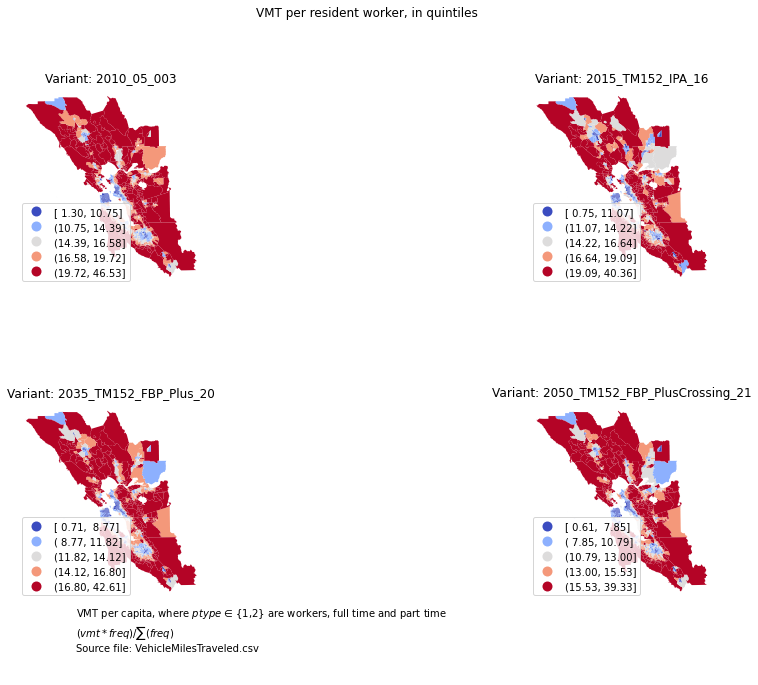

In [40]:
subtitle = '$(vmt*freq)/\sum(freq)$'

fig, ax = plt.subplots(ncols=2,nrows=2, figsize=[10, 10])

ax=ax.ravel()
for i, dta in enumerate(vmt_taz_por.groupby(['year', 'scenario'])):
    dta[1].plot(
        column='value', edgecolor='none', legend=True, legend_kwds={'loc': 'lower left'},
        cmap=cm.coolwarm, scheme='quantiles', ax=ax[i])

    ## title and axis
    ax[i].set_title('Variant: {path}'.format(
        path=vmt_taz_por[vmt_taz_por.year == dta[0][0]].scenario.iloc[0]))

    ax[i].axis('off')

plt.suptitle('VMT per resident worker, in quintiles')
plt.annotate(text='VMT per capita, where $ptype$ ∈ {1,2} are workers, full time and part time\n%s\nSource file: VehicleMilesTraveled.csv'%subtitle, xy=(
    0.1, 0.05), xycoords='figure fraction')
plt.tight_layout()

#### Place of work

(443353.8067403114, 669589.7789759928, 4073188.7697532224, 4312776.476921541)

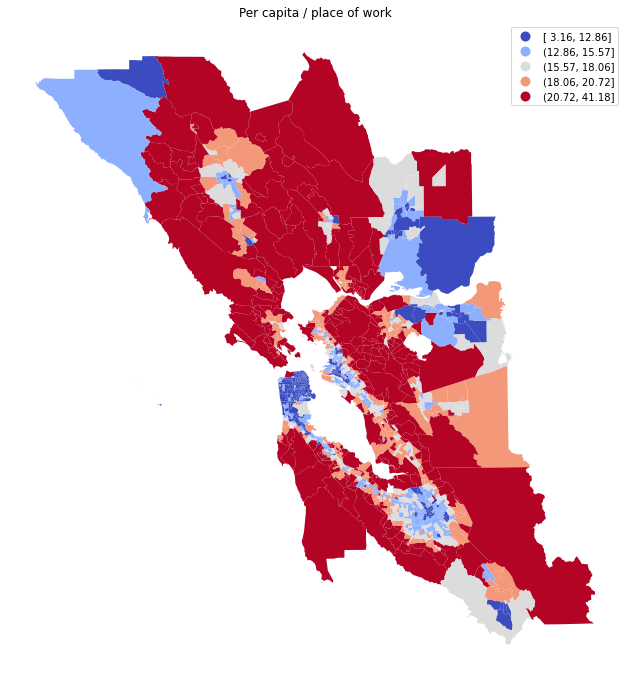

In [41]:
vmt_taz_pow['geometry']=vmt_taz_pow.TAZ.map(taz.set_index('taz1454').geometry)
vmt_taz_pow = gpd.GeoDataFrame(vmt_taz_pow)
vmt_taz_pow = vmt_taz_pow[vmt_taz_pow.is_valid]
ax = vmt_taz_pow.plot(column='value', edgecolor='none', legend=True, figsize=[
                      12, 12], cmap=cm.coolwarm, scheme='quantiles')
ax.set_title('Per capita / place of work')
ax.axis('off')

### Disaggregate VMT to jurisdiction
For this we need not the ratio, but the overall sums (VMT and persons). We apportion those values to juridictions, and then do the vmt per capita.

`taz_to_juris_share_v2` is a multi-indexed (taz, juris) series that says  for each taz-juris combination, how much of the taz's population falls in that jurisdiction. This essentially serves as a weight - take a number in TAZ x, and send shares of this number to the containing juridictions.

In [42]:
taz_to_juris_share_v2

taz       juris               
1.00      San Francisco          1.00
2.00      San Francisco          1.00
3.00      San Francisco          1.00
4.00      San Francisco          1.00
5.00      San Francisco          1.00
                                 ... 
1,451.00  Unincorporated Marin   1.00
1,452.00  Mill Valley            1.00
1,453.00  Sausalito              0.00
          Unincorporated Marin   1.00
1,454.00  Unincorporated Marin   1.00
Name: value, Length: 2226, dtype: float64

In [43]:
# vmt per [denominator], where ptype 1,2 are workers, full time and part time

# sum the vmt and population first, and combine

juris_vmt_taz_por = pd.concat([
    VehicleMilesTraveled[VehicleMilesTraveled.ptype.isin([1, 2])].groupby(
        ['taz', 'year', 'scenario']).apply(lambda x: (x.vmt*x.freq).sum()),
    VehicleMilesTraveled[VehicleMilesTraveled.ptype.isin([1, 2])].groupby(['taz', 'year', 'scenario']).freq.sum()], 
    keys=['vmt', 'population']).unstack(0)
juris_vmt_taz_por.head()

vmt  population
taz year scenario                                         
1   2010 2010_05_003                    104.58       36.00
    2015 2015_TM152_IPA_16              175.66       26.00
    2035 2035_TM152_FBP_Plus_20          79.12       28.00
    2050 2050_TM152_FBP_PlusCrossing_21 522.17      282.00
2   2010 2010_05_003                    162.80       92.00

In [44]:
# Then map TAZ counts to jurisdictions.
# I run as a group by operation to get a clean shot at multiplying a taz-indexed df with the taz_to_juris_share_v2

vmt_juris = {}
for nme, dta in juris_vmt_taz_por.groupby(level=['year', 'scenario']):
    vmt_juris[nme] = dta.reset_index(['year', 'scenario'], drop=True).mul(
        taz_to_juris_share_v2, axis=0)
vmt_juris = pd.concat(vmt_juris, names=['year', 'scenario']).sum(
    level=['year', 'scenario', 'juris'])
vmt_juris['vmt_per_capita'] = vmt_juris.vmt / vmt_juris.population
vmt_juris.tail()

vmt  population  \
year scenario                       juris                                 
2050 2050_TM152_FBP_PlusCrossing_21 Mill Valley  129,481.59    6,964.07   
                                    Corte Madera 113,030.75    6,858.27   
                                    Tiburon      105,224.44    4,636.30   
                                    Belvedere     22,707.59      861.66   
                                    Sausalito    114,497.09    5,403.32   

                                                  vmt_per_capita  
year scenario                       juris                         
2050 2050_TM152_FBP_PlusCrossing_21 Mill Valley            18.59  
                                    Corte Madera           16.48  
                                    Tiburon                22.70  
                                    Belvedere              26.35  
                                    Sausalito              21.19

In [45]:
vmt_juris.loc[['2015','2035','2050']].unstack(['year','scenario']).to_excel(xlwriter,'Commute_VMT_per_capita')

#### Jurisdiction - level map

(443366.310464499, 669592.5451161573, 4073091.2007269957, 4312780.551183573)

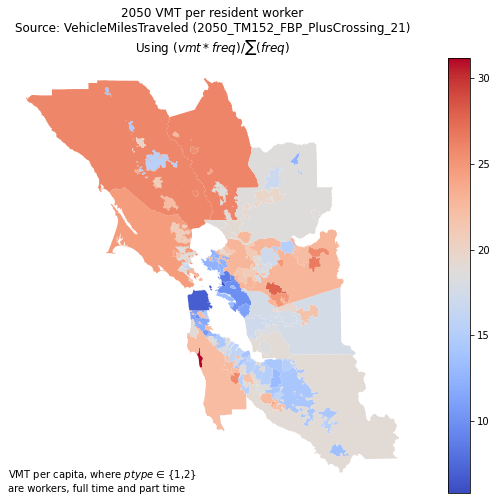

In [46]:
vmt_juris_geom = vmt_juris.unstack(['year', 'scenario'])['vmt_per_capita','2050','2050_TM152_FBP_PlusCrossing_21'].to_frame(name='vmt_per_capita_2050')
vmt_juris_geom['geometry']=jurisdictions.set_index('juris').geometry
ax = gpd.GeoDataFrame(vmt_juris_geom).plot('vmt_per_capita_2050',figsize=[11,8],legend=True,cmap=cm.coolwarm)

MAP_YEAR='2050'
subtitle = '$(vmt*freq)/\sum(freq)$'

ax.set_title('{yr} VMT per resident worker\nSource: VehicleMilesTraveled ({path})\nUsing {expr}'.format(expr=subtitle,yr=MAP_YEAR,path=vmt_taz_por[vmt_taz_por.year==MAP_YEAR].scenario.iloc[0]))
ax.annotate(text='VMT per capita, where $ptype$ ∈ {1,2}\nare workers, full time and part time', xy=(0.7,.95),xycoords='axes points')
ax.axis('off')

In [47]:
# vmt_juris.unstack(['year', 'scenario']).to_excel(
#     '/Users/aolsen/Box/RHNA/HCD Review/juris_VMT_per_capita_ptypes1_3.xlsx')

### Tour mode share by place of residence
https://github.com/BayAreaMetro/modeling-website/wiki/TravelModes#tour-and-trip-modes

In [48]:
# doc_tables = pd.read_html(
#     'https://github.com/BayAreaMetro/modeling-website/wiki/TravelModes#tour-and-trip-modes')
# doc_tables[0].set_index('Number')['Label(s)']


In [49]:
# mapping of 21 modes to more aggregate ones

xw = pd.read_excel(
    '/Users/aolsen/Box/RHNA/HCD Review/mode_shares_crosswalk.xlsx',sheet_name='mapping_21',engine='openpyxl')
xw

,Number,Name,Agglabel
0,1,"Drive alone (single-occupant vehicles), not el...",Drive Alone
1,2,"Drive alone (single-occupant), eligible to use...",Drive Alone
2,3,"Shared ride 2 (two-occupant vehicles), not eli...",Carpool
3,4,"Shared ride 2 (two-occupant vehicles), eligibl...",Carpool
4,5,Shared ride 3+ (three-or-more-occupant vehicle...,Carpool
5,6,Shared ride 3+ (three-of-more occupant vehicle...,Carpool
6,7,"Walk the entire way (no transit, no bicycle)",Walk
7,8,Bicycle the entire way (no transit),Bicycle
8,9,Walk to local bus,Walk-Bus
9,10,Walk to light rail or ferry,Walk-Ferry/Light Rail


In [50]:
CommuteByIncomeHousehold['tour_mode_l'] = CommuteByIncomeHousehold.tour_mode.map(
    xw.set_index('Number').Agglabel)


In [51]:
tour_mode_share_juris = (CommuteByIncomeHousehold
                         .groupby(['year','orig_taz', 'tour_mode_l'])
                         .freq.sum()
                         .reset_index()
                         .rename(columns={'orig_taz': 'taz'})
                         .set_index(['year','taz', 'tour_mode_l']).freq
                         .mul(taz_to_juris_share_v2, axis=0)
                         .sum(level=['juris', 'year','tour_mode_l'])
                         .groupby(level=['juris','year'])
                         .apply(pct)
                         .unstack('tour_mode_l'))

tour_mode_share_juris.loc(0)[:,['2020','2050']].unstack('year').to_excel(xlwriter,'Mode_Share')

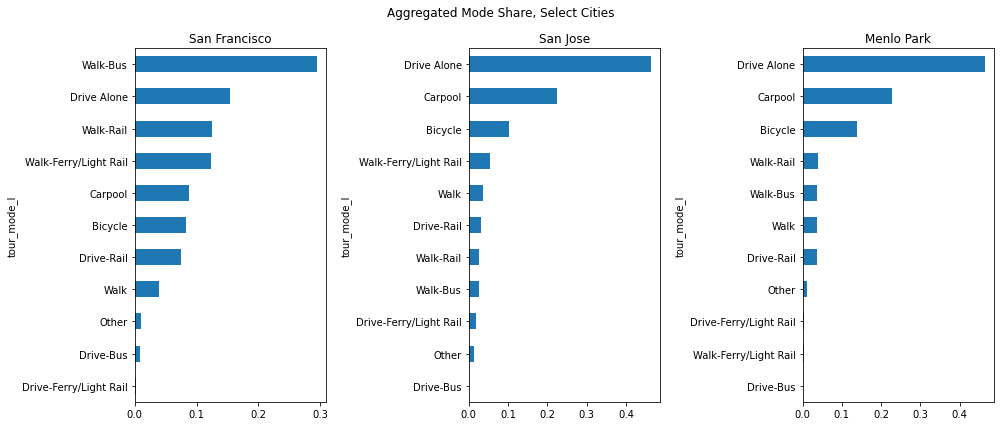

In [52]:
fig, ax=plt.subplots(ncols=3,figsize=[14,6])

tour_mode_share_juris.loc['San Francisco','2050'].sort_values().plot(kind='barh',ax=ax[0])
tour_mode_share_juris.loc['San Jose','2050'].sort_values().plot(kind='barh',ax=ax[1])
tour_mode_share_juris.loc['Menlo Park','2050'].sort_values().plot(kind='barh',ax=ax[2])

ax[0].set_title('San Francisco')
ax[1].set_title('San Jose')
ax[2].set_title('Menlo Park')

plt.suptitle('Aggregated Mode Share, Select Cities')
plt.tight_layout()


#### Drive alone mode share by juris

(443366.310464499, 669592.5451161573, 4073091.2007269957, 4312780.551183573)

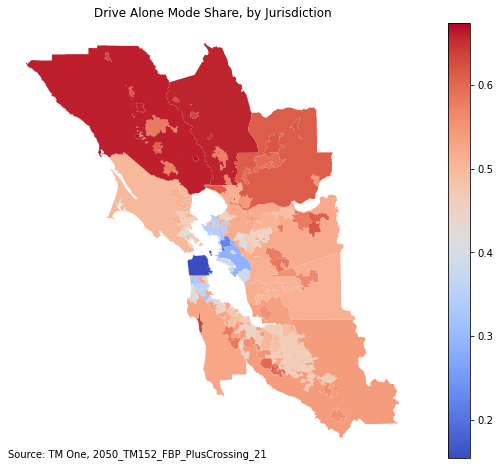

In [53]:
tour_mode_share_juris_geom = tour_mode_share_juris.loc(0)[:,'2050'].reset_index(1,drop=True)
tour_mode_share_juris_geom['geometry']=jurisdictions.set_index('juris').geometry

ax = gpd.GeoDataFrame(tour_mode_share_juris_geom).plot('Drive Alone',figsize=[11,8],legend=True,cmap=cm.coolwarm)


ax.set_title('Drive Alone Mode Share, by Jurisdiction')
ax.annotate(text='Source: TM One, 2050_TM152_FBP_PlusCrossing_21', xy=(0.7,.95),xycoords='axes points')
ax.axis('off')

### Tour distance

In [54]:
# first aggregate up to taz level - unit of analysis is sample record / person
trips_mean_distance = (CommuteByIncomeHousehold
                       .groupby(['year','orig_taz'])
                       .apply(lambda x: pd.Series({'weighted_distance': (x.distance * x.freq).sum(), 'freq': x.freq.sum()}))
                       .reset_index()
                       .rename(columns={'orig_taz': 'taz'})
                       .set_index(['year','taz']))

# then disaggregate counts, weighted distance, and trips, using taz to juris shares
trips_mean_distance_x_juris_numerator = trips_mean_distance.weighted_distance.mul(
    taz_to_juris_share_v2, axis=0)

trips_mean_distance_x_juris_denominator = trips_mean_distance.freq.mul(
    taz_to_juris_share_v2, axis=0)

# divide the juris-level distance with counts to get a ratio as appropriate
trips_mean_distance_x_juris =  trips_mean_distance_x_juris_numerator.groupby(['year','juris'],observed=True).sum()/\
trips_mean_distance_x_juris_denominator.groupby(['year','juris'],observed=True).sum()

trips_mean_distance_x_juris.unstack(0)



year,2010,2015,2035,2050
juris,,,,
Alameda,12.38,11.59,10.83,10.64
Albany,10.86,10.47,10.22,10.94
American Canyon,20.45,14.80,14.84,12.75
Antioch,22.85,18.40,18.81,17.87
Atherton,12.13,12.74,10.14,9.60
...,...,...,...,...
Vallejo,20.16,15.61,16.28,14.72
Walnut Creek,15.48,13.09,15.02,15.05
Windsor,15.84,10.70,10.55,10.03


(443366.310464499, 669592.5451161573, 4073091.2007269957, 4312780.551183573)

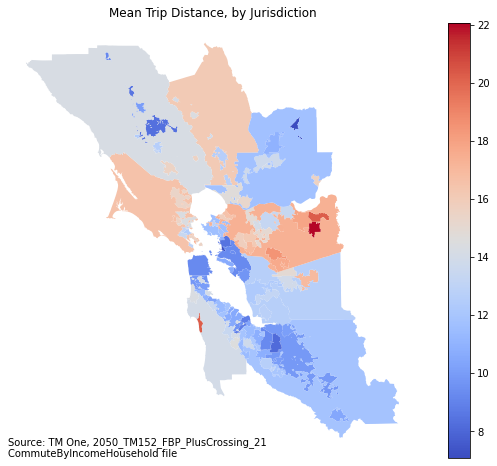

In [55]:
trips_mean_distance_x_juris.loc(0)[['2015','2035','2050']].unstack('year').to_excel(xlwriter,'Mean_Distance')

trips_mean_distance_x_juris_geo = trips_mean_distance_x_juris.unstack('year')['2050'].to_frame('mean_distance')

trips_mean_distance_x_juris_geo['geometry']=jurisdictions.set_index('juris').geometry


ax = gpd.GeoDataFrame(trips_mean_distance_x_juris_geo).plot('mean_distance',figsize=[11,8],legend=True,cmap=cm.coolwarm)


ax.set_title('Mean Trip Distance, by Jurisdiction')
ax.annotate(text='Source: TM One, 2050_TM152_FBP_PlusCrossing_21\nCommuteByIncomeHousehold file', xy=(0.7,.95),xycoords='axes points')
ax.axis('off')

### Tour duration

In [57]:
# first aggregate up to taz level - unit of analysis is sample record / person
trips_mean_duration = (CommuteByIncomeHousehold
                       .groupby(['year','orig_taz'])
                       .apply(lambda x: pd.Series({'weighted_duration': (x.duration * x.freq).sum(), 'freq': x.freq.sum()}))
                       .reset_index()
                       .rename(columns={'orig_taz': 'taz'})
                       .set_index(['year','taz']))

# then disaggregate counts, weighted duration, and trips, using taz to juris shares
trips_mean_duration_x_juris_numerator = trips_mean_duration.weighted_duration.mul(
    taz_to_juris_share_v2, axis=0)

trips_mean_duration_x_juris_denominator = trips_mean_duration.freq.mul(
    taz_to_juris_share_v2, axis=0)

# divide the juris-level duration with counts to get a ratio as appropriate
trips_mean_duration_x_juris =  trips_mean_duration_x_juris_numerator.groupby(['year','juris'],observed=True).sum()/\
trips_mean_duration_x_juris_denominator.groupby(['year','juris'],observed=True).sum()

trips_mean_duration_x_juris.unstack(0)


year,2010,2015,2035,2050
juris,,,,
Alameda,29.96,26.90,29.87,29.50
Albany,31.44,28.00,31.73,32.01
American Canyon,36.11,24.78,29.63,25.80
Antioch,43.00,30.45,37.94,35.58
Atherton,24.55,24.43,25.56,25.46
...,...,...,...,...
Vallejo,36.21,26.09,32.09,29.30
Walnut Creek,32.37,24.64,33.55,34.04
Windsor,26.11,19.70,21.44,20.72


(443366.310464499, 669592.5451161573, 4073091.2007269957, 4312780.551183573)

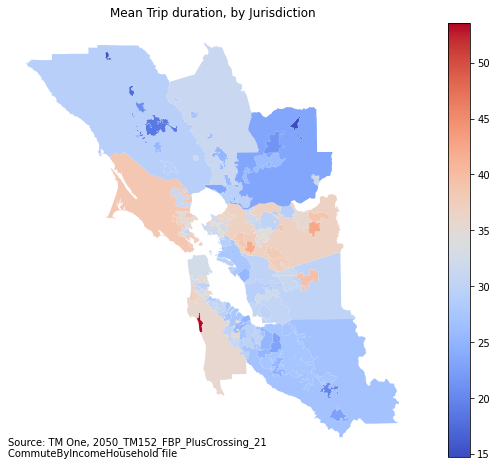

In [58]:
trips_mean_duration_x_juris.loc(0)[['2015','2035','2050']].unstack('year').to_excel(xlwriter,'Mean_Duration')

trips_mean_duration_x_juris_geo = trips_mean_duration_x_juris.unstack('year')['2050'].to_frame('mean_duration')

trips_mean_duration_x_juris_geo['geometry']=jurisdictions.set_index('juris').geometry


ax = gpd.GeoDataFrame(trips_mean_duration_x_juris_geo).plot('mean_duration',figsize=[11,8],legend=True,cmap=cm.coolwarm)


ax.set_title('Mean Trip duration, by Jurisdiction')
ax.annotate(text='Source: TM One, 2050_TM152_FBP_PlusCrossing_21\nCommuteByIncomeHousehold file', xy=(0.7,.95),xycoords='axes points')
ax.axis('off')

In [59]:
pd.concat([trips_mean_distance_x_juris,
          trips_mean_duration_x_juris],keys=['distance','duration']).unstack(0).corr()

,distance,duration
distance,1.00,0.72
duration,0.72,1.00


In [60]:
# close excel writer object
xlwriter.close()